## An Analysis of socio-economic factors on national graduation rate

This project uses the EDFacts data consisting of district level statistics on graduation rates and performance on math & reading/language art assessments by race/ethnicity, gender, disability, English proficiency and socioeconomic status for two years 2011 and 2014. The objective of the project is

1) Determine if correlations between these variables (race, poverty, disabilities etc.) and cohort graduation rates exist. Does any state has less cohort graduation rate compare to another state? What variables most influence the cohort graduation rate per state?

2) Determine if there is a statistically significant difference between Northeast, Midwest, South and West region in cohort graduation rate per district. Perform k-means clustering to discover if cohort data can accurately predict a region.

3) Create regression model using machine learning to predict cohort graduation rate per district given EDFacts data for a particular district. This model could be used to granularize the district into schools and provide more localized estimates of cohort graduation rate.

In [1]:
%pylab inline

import re
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
sns.set_style(style='white')

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import statsmodels as sm
from scipy import stats
from statsmodels.stats.weightstats import ztest
import geopandas as gpd
import pysal

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Populating the interactive namespace from numpy and matplotlib


## Data Exploration

To begin, we'll examine relationships in the cohort graduation data set. Later in the analysis, we will pull in EDFacts data to understand each district's racial distribution, ELSI data, poverty data and assessment data, etc.
First, we'll look at two statements made by Department of Education when introducing this dataset:

1) In school year 2014–15, the adjusted cohort graduation rate (ACGR) for public high school students rose to 83 percent, the highest rate since the measure was first collected in 2010–11.

2) Asian/Pacific Islander students had the highest ACGR (90 percent), followed by White (88 percent), Hispanic (78 percent), Black (75 percent), and American Indian/Alaska Native (72 percent) students

* https://nces.ed.gov/programs/coe/indicator_coi.asp

### Average adjusted cohort graduation rate (ACGR)

##### First, let's test the statement made by Department of Education that "In school year 2014-15, the adjusted cohort graduation rate (ACGR) for public high school students rose to 83%"

In [2]:
acgr2011 = pd.read_csv("data/high-school-dropout-dataset2011.csv", dtype={"LEAID": str})
acgr2014 = pd.read_csv("data/high-school-dropout-dataset2014.csv", dtype={"LEAID": str})

acgr2011 = acgr2011[acgr2011['ALLP'] != 0]
acgr2014 = acgr2014[acgr2014['ALLP'] != 0]

In [3]:
nationalacgr2011 = round(np.sum(acgr2011['ALLG'])*100/np.sum(acgr2011['ALLA']),2)
nationalacgr2014 = round(np.sum(acgr2014['ALLG'])*100/np.sum(acgr2014['ALLA']),2)

print(color.BOLD + '\nAfter verifying the clean regulatory adjusted cohort graduation rate for all district we can \nsee that in school year 2014-15 the graduation rate at the national level is %s%%, an \nincrease from %s%% in 2011-12. \nHow does the graduation rate vary depending on the state? This will be explored later in the analysis.' 
      %(nationalacgr2014, nationalacgr2011) + color.BOLD)


After verifying the clean regulatory adjusted cohort graduation rate for all district we can 
see that in school year 2014-15 the graduation rate at the national level is 85.6%, an 
increase from 82.11% in 2011-12. 
How does the graduation rate vary depending on the state? This will be explored later in the analysis.


##### Now, let's verify the other statement made by Department of Education that "In school year 2014-15, Asian/Pacific Islander students had the highest ACGR of 90%, followed by White 88%, Hispanic 78%, Black 75% and American Indian/Alaska Native 72% students.

In [4]:
acgrMAM2014 = round(np.sum(acgr2014['MAMG'])*100/np.sum(acgr2014['MAMA']),0)
acgrMAS2014 = round(np.sum(acgr2014['MASG'])*100/np.sum(acgr2014['MASA']),0)
acgrMBL2014 = round(np.sum(acgr2014['MBLG'])*100/np.sum(acgr2014['MBLA']),0)
acgrMHI2014 = round(np.sum(acgr2014['MHIG'])*100/np.sum(acgr2014['MHIA']),0)
acgrMWH2014 = round(np.sum(acgr2014['MWHG'])*100/np.sum(acgr2014['MWHA']),0)

print(color.BOLD + '\nAfter calculating the cohort graduation rate for major racial and ethnic groups, we can see \nthat in school year 2014–15 Asian/Pacific Islander students has the highest ACGR of %s%%, \nfollowed by white %s%%, Hispanic %s%%, Black %s%% and American Indian/Alaska Native \n%s%%.' 
      %(acgrMAS2014, acgrMWH2014, acgrMHI2014, acgrMBL2014, acgrMAM2014), color.BOLD)


After calculating the cohort graduation rate for major racial and ethnic groups, we can see 
that in school year 2014–15 Asian/Pacific Islander students has the highest ACGR of 87.0%, 
followed by white 89.0%, Hispanic 80.0%, Black 76.0% and American Indian/Alaska Native 
59.0%. 


##### Now let's verify how the cohort graduation rate for major racial and ethnic groups changed from SY 2011-12 to SY 2014-15.

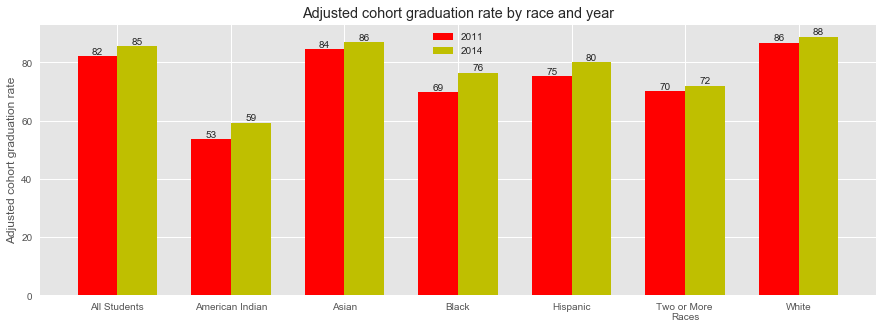

In [5]:
frames = [acgr2011, acgr2014]
acgrdf = pd.concat(frames)

acgrByYr = round(acgrdf.groupby(['YEAR'], as_index=False)['ALLA','ALLG','MAMG','MAMA','MASG','MASA','MBLG','MBLA',
                                                          'MHIG','MHIA','MTRG','MTRA','MWHG','MWHA','CWDG','CWDA',
                                                          'ECDG','ECDA','LEPG','LEPA'].sum(),2)
acgrByYr['ALLP'] = round(acgrByYr['ALLG']*100/acgrByYr['ALLA'],2)
acgrByYr['MAMP'] = round(acgrByYr['MAMG']*100/acgrByYr['MAMA'],2)
acgrByYr['MASP'] = round(acgrByYr['MASG']*100/acgrByYr['MASA'],2)
acgrByYr['MBLP'] = round(acgrByYr['MBLG']*100/acgrByYr['MBLA'],2)
acgrByYr['MHIP'] = round(acgrByYr['MHIG']*100/acgrByYr['MHIA'],2)
acgrByYr['MTRP'] = round(acgrByYr['MTRG']*100/acgrByYr['MTRA'],2)
acgrByYr['MWHP'] = round(acgrByYr['MWHG']*100/acgrByYr['MWHA'],2)
acgrByYr['CWDP'] = round(acgrByYr['CWDG']*100/acgrByYr['CWDA'],2)
acgrByYr['ECDP'] = round(acgrByYr['ECDG']*100/acgrByYr['ECDA'],2)
acgrByYr['LEPP'] = round(acgrByYr['LEPG']*100/acgrByYr['LEPA'],2)

import numpy as np
import matplotlib.pyplot as plt

N = 7

acgr11 = tuple(tuple(acgrByYr.iloc[0:1,21:28].values)[0])
#acgr11 = (82.09,53.40,84.61,69.84,75.32,70.03,86.79)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(ind, acgr11, width, color='r')

acgr14 = tuple(tuple(acgrByYr.iloc[1:2,21:28].values)[0])
#acgr14 = (85.55,59.24,86.73,76.35,79.99,72.03,88.84)

rects2 = ax.bar(ind + width, acgr14, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Adjusted cohort graduation rate')
ax.set_title('Adjusted cohort graduation rate by race and year')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('All Students','American Indian','Asian','Black','Hispanic',
                    'Two or More \nRaces','White'))

ax.legend((rects1[0], rects2[0]), ('2011', '2014'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

#### From the Adjusted cohort graduation rate by race and year we can conclude that the increase in the overall cohort graduation rate is contributed by each race but they may not have contributed at the same rate. Later we will analyze which race has more impact on the overall graduation rate.

##### Now check the states which are doing better than other state. In order to have a better visual representation we have plotted the chloropleth map with the data from school year 2014-15 after removing Hawaii and Alaska.



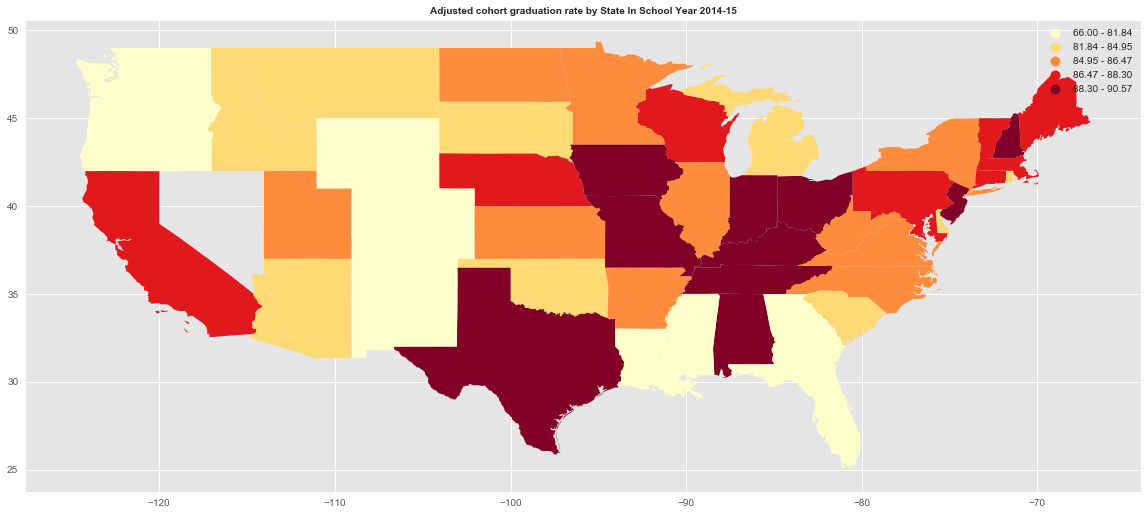

In [6]:
acgrBySt2011 = round(acgr2011.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2011 = acgrBySt2011.sort_values('ALLA', ascending=False)
acgrBySt2011['ALLP'] = round(acgrBySt2011['ALLG']*100/acgrBySt2011['ALLA'],2)

acgrBySt2014 = round(acgr2014.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2014 = acgrBySt2014.sort_values('ALLA', ascending=False)
acgrBySt2014['ALLP'] = round(acgrBySt2014['ALLG']*100/acgrBySt2014['ALLA'],2)

sf = gpd.GeoDataFrame.from_file("data/states_21basic/states.shp")

sf['STATE_FIPS'] = pd.to_numeric(sf['STATE_FIPS'])
sf.rename(index=str, columns={"STATE_FIPS": "FIPCD"}, inplace=True)

response_map = pd.merge(sf,acgrBySt2014,on='FIPCD')
response_map = response_map[response_map['STATE_NAME'] != 'Hawaii']
response_map = response_map[response_map['STATE_NAME'] != 'Alaska']

ax = response_map.plot(column='ALLP', scheme='quantiles', k=5, cmap='YlOrRd', legend=True, figsize=(20,10));
ax.set_title('Adjusted cohort graduation rate by State In School Year 2014-15', fontsize = 10, fontweight = 'bold');
plt.show()

#### From the above heatmap it is very clear that the school district in Northeast and South region is doing better than the school district in Midwest and west region. Now check how these states are doing over time.

#### Next, I compared the means of all the critical factors which can impact the adjusted cohort graduation rates in 2011 with 2014

In [7]:
frames = [acgr2011, acgr2014]

tempDf = pd.concat(frames)

tempComb = tempDf[['YEAR','ALLP','MAMR','MASR','MBLR','MHIR','MWHR','MTRR','CWDR','ECDR', 
                   'LEPR','MTHP','RLAP','CHIR','POVR','CHSR','PUTR','MLSR','FLSR','FRLR',
                   'SETR','SECR']]

acgrComb = tempComb.rename(index=str, columns={
            'ALLP': '% of students graduated', 
            'MAMR': '% Appeared - American Indian', 
            'MASR': '% Appeared - Asian', 
            'MBLR': '% Appeared - Black',
            'MHIR': '% Appeared - Hispanic', 
            'MWHR': '% Appeared - White',
            'MTRR': '% Appeared - Two or More Races', 
            'CWDR': '% Appeared - Children with disabilities',
            'ECDR': '% Appeared - Economically disadvantaged', 
            'LEPR': '% Appeared - Limited English proficient',
            'MTHP': '% Proficient - Math', 
            'RLAP': '% Proficient - ELA',
            'CHIR': '% of Children',
            'POVR': '% of Children under poverty',
            'CHSR': '% of Charter School', 
            'PUTR': 'Pupil/Teacher Ratio',
            'MLSR': '% of male students',
            'FLSR': '% of female students',
            'FRLR': '% of Students on free/reduced lunch', 
            'SETR': '% of secondary teachers',
            'SECR': '% of secondary counselors'
            })
    
crifacByYr = round(acgrComb.groupby(['YEAR'], as_index=False).mean(),2)

crifac = crifacByYr.iloc[:,1:22].T
crifac = crifac.rename(index=str, columns={0: '2011', 1: '2014'})
crifac['% Change'] = round((crifac['2014'] - crifac['2011'])*100/crifac['2011'],2)
crifac

,2011,2014,% Change
% of students graduated,84.95,86.75,2.12
% Appeared - American Indian,1.90,2.60,36.84
% Appeared - Asian,1.89,1.98,4.76
% Appeared - Black,8.41,7.81,-7.13
% Appeared - Hispanic,10.66,11.72,9.94
% Appeared - White,75.72,73.95,-2.34
% Appeared - Two or More Races,1.20,1.82,51.67
% Appeared - Children with disabilities,12.98,12.59,-3.00
% Appeared - Economically disadvantaged,40.44,43.75,8.18
% Appeared - Limited English proficient,2.68,2.76,2.99


#### The state wise mean adjusted cohort graduation rate in 2011 and 2014 (i.e., ALLP) were sorted to find the top five state having lowest graduation rate for both these years

In [9]:
#Get State Code From State Code
def getStateCode(statecode):
    data = pd.read_csv('data/state.txt')
    dfstate = data.loc[data['CODE'] == statecode]
    
    return dfstate.ST.values

#Get FIPS Code From State Name
def getStateName(statecode):
    data = pd.read_csv('data/state.txt')
    dfstate = data.loc[data['CODE'] == statecode]
    
    return dfstate.STATENAME.values

acgrBySt2011 = acgrBySt2011.sort_values('ALLP')
acgrBySt2011['STATE'] = acgrBySt2011['FIPCD'].map(getStateName)
print(acgrBySt2011.head(5)[['STATE', 'ALLP']].to_string(index=False))
print(acgrBySt2011.tail(5)[['STATE', 'ALLP']].to_string(index=False))
acgrBySt2014 = acgrBySt2014.sort_values('ALLP')
acgrBySt2014['STATE'] = acgrBySt2014['FIPCD'].map(getStateName)
print(acgrBySt2014.head(5)[['STATE', 'ALLP']].to_string(index=False))
print(acgrBySt2014.tail(5)[['STATE', 'ALLP']].to_string(index=False))

STATE   ALLP
[DISTRICT OF COLUMBIA]  54.01
              [NEVADA]  64.38
              [OREGON]  69.01
              [ALASKA]  69.08
             [GEORGIA]  70.60
STATE   ALLP
[WISCONSIN]  87.29
  [VERMONT]  87.78
     [OHIO]  88.13
     [IOWA]  88.67
    [TEXAS]  88.98
STATE   ALLP
[DISTRICT OF COLUMBIA]  66.00
          [NEW MEXICO]  69.81
              [OREGON]  74.62
              [ALASKA]  75.33
             [FLORIDA]  77.88
STATE   ALLP
 [MISSOURI]  89.76
  [INDIANA]  89.87
     [IOWA]  89.91
    [TEXAS]  90.25
[TENNESSEE]  90.57


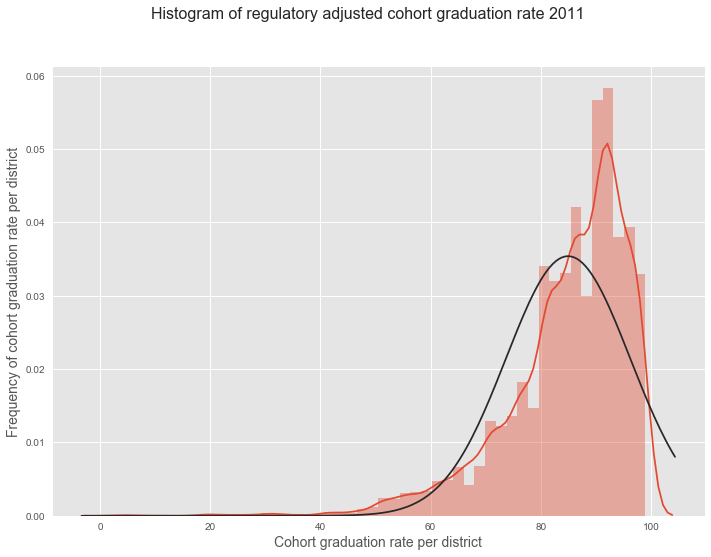

In [10]:
from scipy.stats import norm

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.distplot(acgr2011['ALLP'], fit=norm, kde=True)

fig.suptitle("Histogram of regulatory adjusted cohort graduation rate 2011", fontsize = 16)

plt.xlabel('Cohort graduation rate per district', fontsize=14)
plt.ylabel('Frequency of cohort graduation rate per district', fontsize=14)

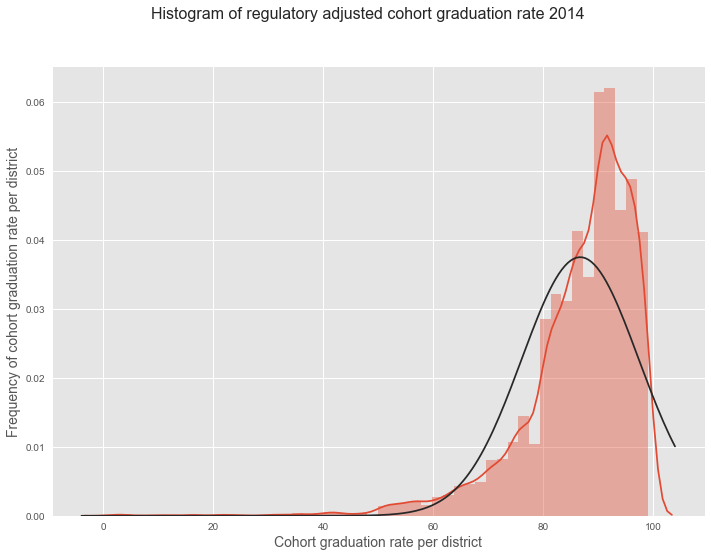

In [11]:
from scipy.stats import norm

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.distplot(acgr2014['ALLP'], fit=norm, kde=True)

fig.suptitle("Histogram of regulatory adjusted cohort graduation rate 2014", fontsize = 16)

plt.xlabel('Cohort graduation rate per district', fontsize=14)
plt.ylabel('Frequency of cohort graduation rate per district', fontsize=14)

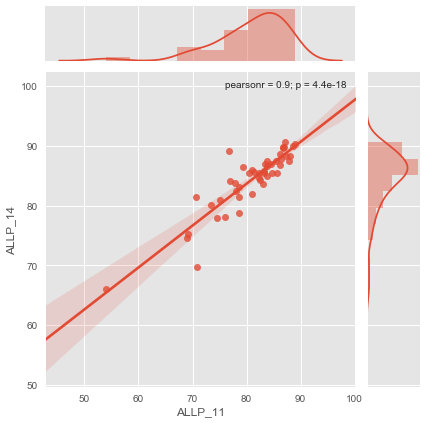

In [12]:
acgrBySt2011 = round(acgr2011.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2011 = acgrBySt2011.sort_values('ALLA', ascending=False)
acgrBySt2011['ALLP'] = round(acgrBySt2011['ALLG']*100/acgrBySt2011['ALLA'],2)

acgrBySt2014 = round(acgr2014.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2014 = acgrBySt2014.sort_values('ALLA', ascending=False)
acgrBySt2014['ALLP'] = round(acgrBySt2014['ALLG']*100/acgrBySt2014['ALLA'],2)

dfcomb1 = pd.merge(acgrBySt2011, acgrBySt2014, how='inner', on= ['FIPCD'], left_index=False, right_index=False, sort=True, 
         suffixes=('_11', '_14'))
dfcomb2 = dfcomb1[['ALLP_11','ALLP_14']]

sns.jointplot(x="ALLP_11", y="ALLP_14", data=dfcomb2, kind="reg");

plt.show()

#### The above scatter plot, X-axis is showing the % of students graduated for each state in 2014 and the Y-axis is showing the % of students graduated for each state in 2011.

#### From this diagram this is clear that most of states are doing consistenyly well except few states. Let us draw a comparison between all states and find out which states doing showing positive growth in % of students graduated.

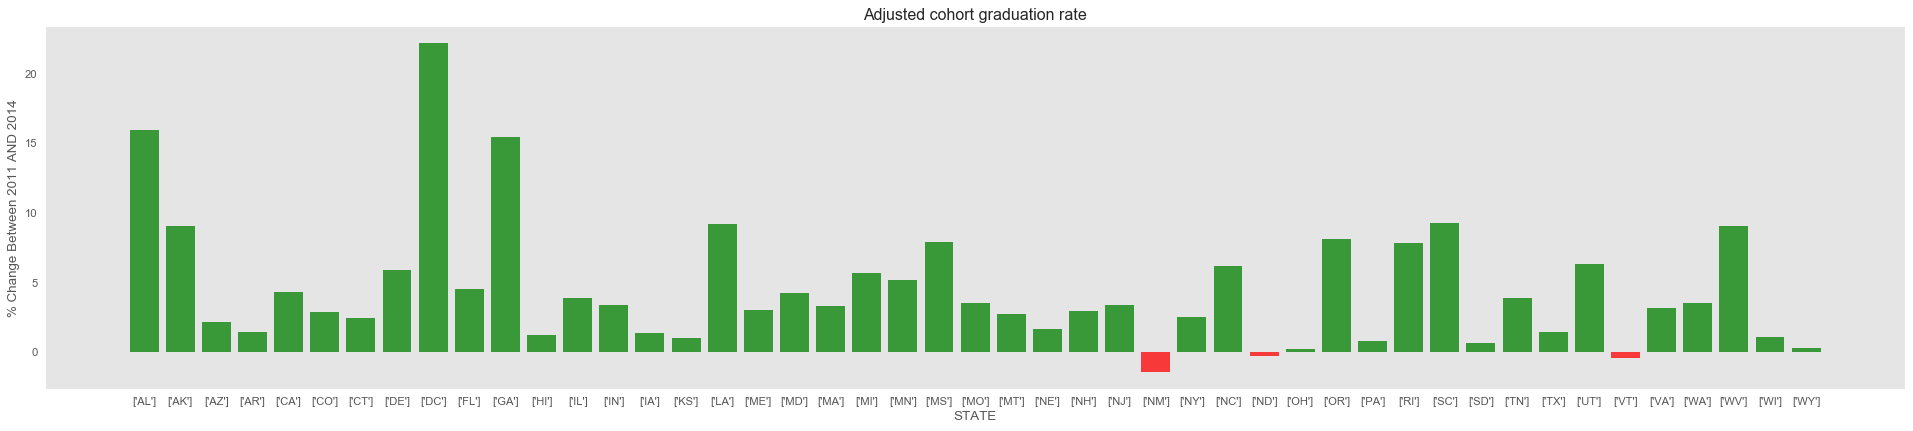

From the above histogram it is clear that most states shown positive growth in cohort 
graduation rate. 
But NEW MEXICO,NORTH DAKOTA,VERMONT are the states showing negative growth in cohort 
graduation rate. 


In [13]:
temp11 = acgrBySt2011[['FIPCD', 'ALLP']]
temp11 = temp11.groupby(['FIPCD'], as_index=False).mean()

temp14 = acgrBySt2014[['FIPCD', 'ALLP']]
temp14 = temp14.groupby(['FIPCD'], as_index=False).mean()

dfcomb = pd.merge(temp11, temp14, how='inner', on= ['FIPCD'], left_index=False, right_index=False, sort=True, 
         suffixes=('_11', '_14'))

dfcomb['Change'] = ((dfcomb['ALLP_14'] - dfcomb['ALLP_11']) / dfcomb['ALLP_11']) * 100
dfcomb['Index'] = dfcomb['FIPCD'].map(getStateCode)
dfcomb['positive'] = dfcomb['Change'] > 0
dfcomb['FIPCD'].map(getStateCode)
    
plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')

objects = dfcomb['Index']
y_pos = np.arange(len(objects))
performance = dfcomb['Change']
 
plt.bar(y_pos, performance, align='center', alpha=0.75, color=dfcomb.positive.map({True: 'g', False: 'r'}))
plt.xticks(y_pos, objects)
plt.xlabel('STATE')
plt.ylabel('% Change Between 2011 AND 2014')
plt.title('Adjusted cohort graduation rate')
plt.grid()

plt.show()

print(color.BOLD + 'From the above histogram it is clear that most states shown positive growth in cohort \ngraduation rate.', color.BOLD)

dfStWithNegGr = dfcomb[dfcomb['positive'] != True]['FIPCD'].map(getStateName)
dfStWithNegGr = dfStWithNegGr.to_string(index = False)
dfStWithNegGr = re.sub( '\n', ',', dfStWithNegGr ).strip()
dfStWithNegGr = re.sub( ',\s+', ',', dfStWithNegGr ).strip()
dfStWithNegGr = dfStWithNegGr.replace('[', '').replace(']', '')

print(color.BOLD + 'But %s are the states showing negative growth in cohort \ngraduation rate.' 
      %(dfStWithNegGr), color.BOLD)

##### Now we will verify the relation between the graduation rate and the % of major racial and ethnic groups in these states and try to find any pattern.

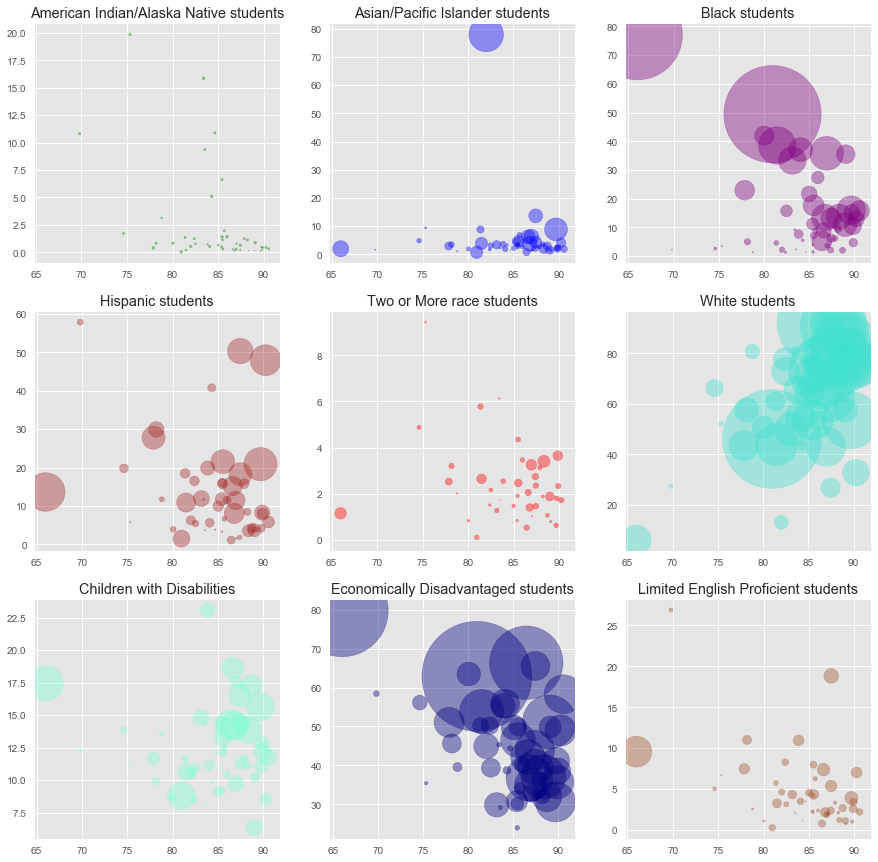

In [14]:
acgrBySt = round(acgr2014.groupby(['FIPCD'], as_index=False)[
    'ALLA', 'ALLG', 'MAMG', 'MAMA', 'MASG', 'MASA', 'MBLG', 'MBLA', 'MHIG', 'MHIA',
    'MWHG', 'MWHA', 'MTRG', 'MTRA', 'CWDG', 'CWDA', 'ECDG', 'ECDA', 'LEPG', 'LEPA'
    ].sum(),2)

acgrBySt = acgrBySt.sort_values('ALLA', ascending=False)
acgrBySt['ALLP'] = round(acgrBySt['ALLG']*100/acgrBySt['ALLA'],2)

acgrBySt['MAMP'] = round(acgrBySt['MAMG']*100/acgrBySt['MAMA'],2)
acgrBySt['MAMR'] = round(acgrBySt['MAMA']*100/acgrBySt['ALLA'],2)

acgrBySt['MASP'] = round(acgrBySt['MASG']*100/acgrBySt['MAMA'],2)
acgrBySt['MASR'] = round(acgrBySt['MASA']*100/acgrBySt['ALLA'],2)

acgrBySt['MBLP'] = round(acgrBySt['MBLG']*100/acgrBySt['MAMA'],2)
acgrBySt['MBLR'] = round(acgrBySt['MBLA']*100/acgrBySt['ALLA'],2)

acgrBySt['MHIP'] = round(acgrBySt['MHIG']*100/acgrBySt['MAMA'],2)
acgrBySt['MHIR'] = round(acgrBySt['MHIA']*100/acgrBySt['ALLA'],2)

acgrBySt['MWHP'] = round(acgrBySt['MWHG']*100/acgrBySt['MAMA'],2)
acgrBySt['MWHR'] = round(acgrBySt['MWHA']*100/acgrBySt['ALLA'],2)

acgrBySt['MTRP'] = round(acgrBySt['MTRG']*100/acgrBySt['MAMA'],2)
acgrBySt['MTRR'] = round(acgrBySt['MTRA']*100/acgrBySt['ALLA'],2)

acgrBySt['CWDP'] = round(acgrBySt['CWDG']*100/acgrBySt['MAMA'],2)
acgrBySt['CWDR'] = round(acgrBySt['CWDA']*100/acgrBySt['ALLA'],2)

acgrBySt['ECDP'] = round(acgrBySt['ECDG']*100/acgrBySt['MAMA'],2)
acgrBySt['ECDR'] = round(acgrBySt['ECDA']*100/acgrBySt['ALLA'],2)

acgrBySt['LEPP'] = round(acgrBySt['LEPG']*100/acgrBySt['MAMA'],2)
acgrBySt['LEPR'] = round(acgrBySt['LEPA']*100/acgrBySt['ALLA'],2)

acgrBySt = acgrBySt.fillna(0)

a = acgrBySt['ALLP']
b = acgrBySt['MAMR']
c = acgrBySt['MASR']
d = acgrBySt['MBLR']
e = acgrBySt['MHIR']
f = acgrBySt['MTRR']
g = acgrBySt['MWHR']
h = acgrBySt['CWDR']
i = acgrBySt['ECDR']
j = acgrBySt['LEPR']

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

area = acgrBySt['MAMP']/10
ax[0, 0].scatter(a, b, s=area, color='green', alpha=0.4)
ax[0, 0].set_title("American Indian/Alaska Native students")

area = acgrBySt['MASP']/10
ax[0, 1].scatter(a, c, s=area, color='blue', alpha=0.4)
ax[0, 1].set_title("Asian/Pacific Islander students")

area = acgrBySt['MBLP']/10
ax[0, 2].scatter(a, d, s=area, color='purple', alpha=0.4)
ax[0, 2].set_title("Black students");

area = acgrBySt['MHIP']/10
ax[1, 0].scatter(a, e, s=area, color='brown', alpha=0.4)
ax[1, 0].set_title("Hispanic students");

area = acgrBySt['MTRP']/10
ax[1, 1].scatter(a, f, s=area, color='red', alpha=0.4)
ax[1, 1].set_title("Two or More race students");

area = acgrBySt['MWHP']/10
ax[1, 2].scatter(a, g, s=area, color='Turquoise', alpha=0.4)
ax[1, 2].set_title("White students");

area = acgrBySt['CWDP']/10
ax[2, 0].scatter(a, h, s=area, color='Aquamarine', alpha=0.4)
ax[2, 0].set_title("Children with Disabilities");

area = acgrBySt['ECDP']/10
ax[2, 1].scatter(a, i, s=area, color='Navy', alpha=0.4)
ax[2, 1].set_title("Economically Disadvantaged students");

area = acgrBySt['LEPP']/10
ax[2, 2].scatter(a, j, s=area, color='Sienna', alpha=0.4)
ax[2, 2].set_title("Limited English Proficient students");

plt.show()

#### The above scatter plot is showing the % of students graduated in X-axis, % of students belong to a race in the Y-axis and the size of each bubble is representing the % of students graduated from the same race.

#### From this diagram it is clear that % of American Indian/Alaska Native students and students with two or more has very less impact on the overall graduation rate.

In [15]:
columns = ['ALLP','MAMR','MASR','MBLR','MHIR','MTRR','MWHR','CWDR','ECDR','LEPR','MTHP', 
           'RLAP','CHIR','POVR','CHSR','PUTR','MLSR','FLSR','FRLR','SETR','SECR']

acgr14 = acgr2014[columns]

When dealing with a set of data, often the first thing to do is get a sense for how the variables are distributed. The most convenient way to take a quick look at a distribution is a histogram Now check how the variables are distributed at the district level for school year 2014-15.

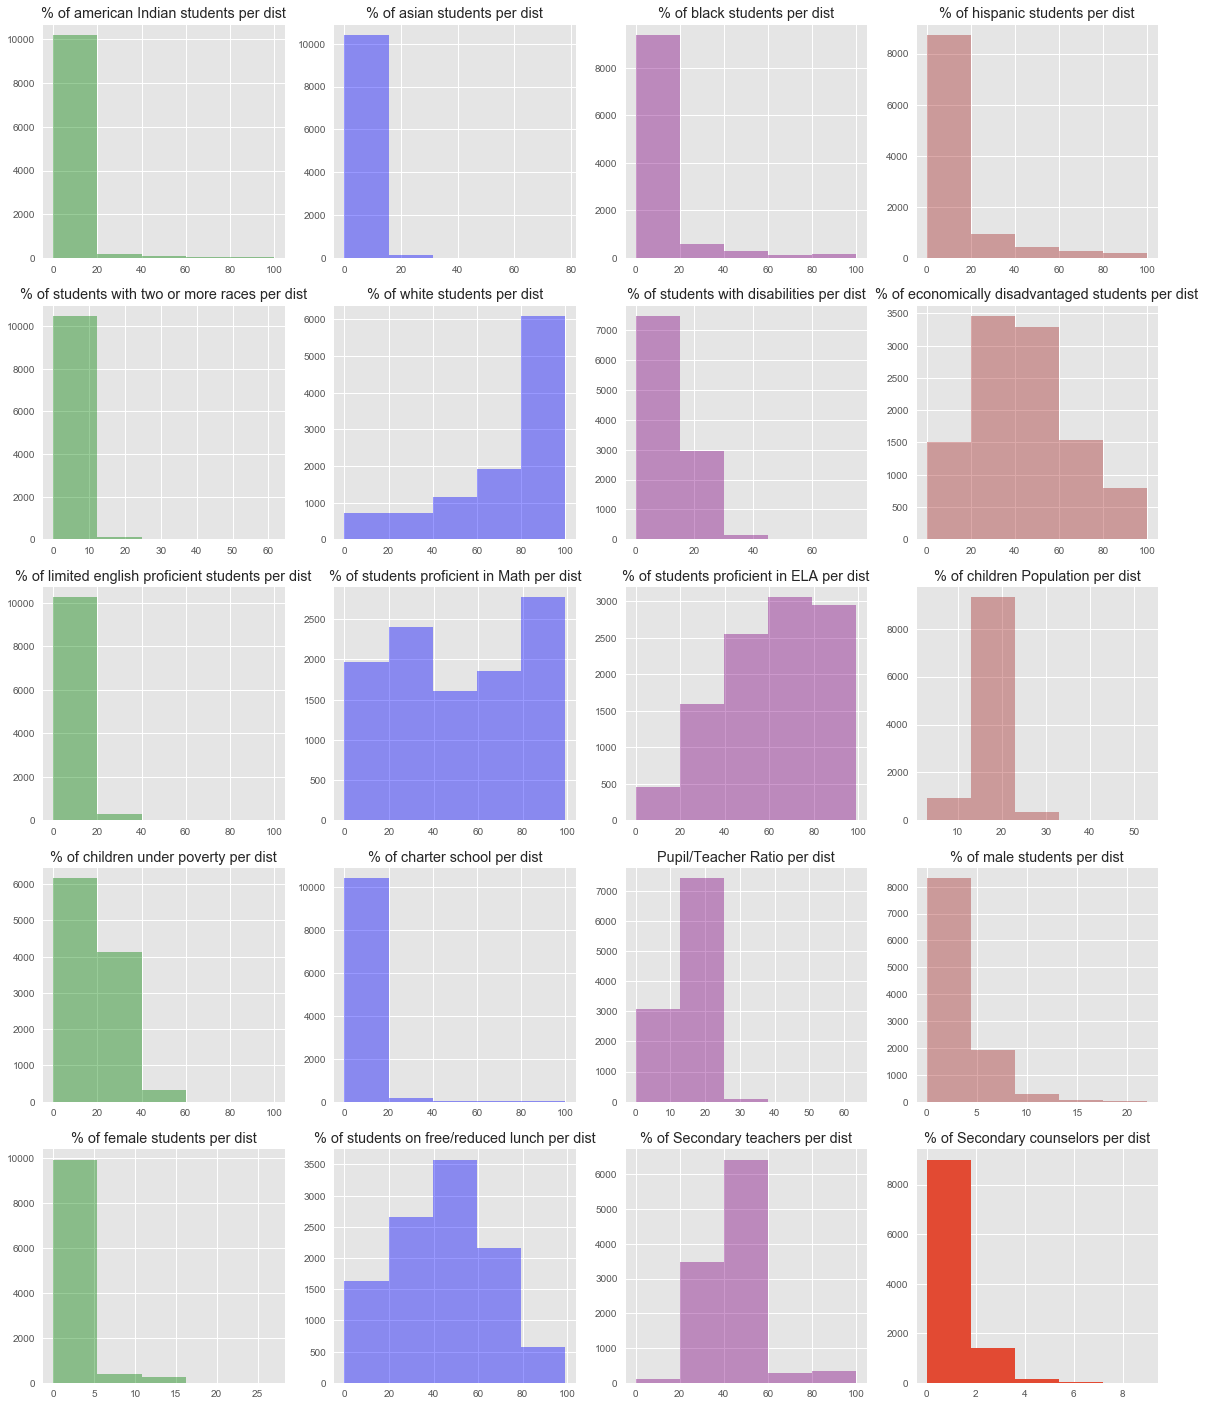

In [16]:
a = acgr14['MAMR']
b = acgr14['MASR']
c = acgr14['MBLR']
d = acgr14['MHIR']
e = acgr14['MTRR']
f = acgr14['MWHR']
g = acgr14['CWDR']
h = acgr14['ECDR']
i = acgr14['LEPR']
j = acgr14['MTHP']
k = acgr14['RLAP']
l = acgr14['CHIR']
m = acgr14['POVR']
n = acgr14['CHSR']
o = acgr14['PUTR']
p = acgr14['MLSR']
q = acgr14['FLSR']
r = acgr14['FRLR']
s = acgr14['SETR']
t = acgr14['SECR']

fig, ax = plt.subplots(5, 4, figsize=(20, 25))

ax[0, 0].hist(a, bins=5, histtype='bar',color="green",alpha=0.4)
ax[0, 0].set_title("% of american Indian students per dist")

ax[0, 1].hist(b, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[0, 1].set_title("% of asian students per dist")

ax[0, 2].hist(c, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[0, 2].set_title("% of black students per dist")

ax[0, 3].hist(d, bins=5, histtype='bar',color="brown",alpha=0.4)
ax[0, 3].set_title("% of hispanic students per dist")

ax[1, 0].hist(e, bins=5, histtype='bar',color="green",alpha=0.4)
ax[1, 0].set_title("% of students with two or more races per dist")

ax[1, 1].hist(f, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[1, 1].set_title("% of white students per dist")

ax[1, 2].hist(g, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[1, 2].set_title("% of students with disabilities per dist")

ax[1, 3].hist(h, bins=5, histtype='bar',color="brown",alpha=0.4)
ax[1, 3].set_title("% of economically disadvantaged students per dist")

ax[2, 0].hist(i, bins=5, histtype='bar',color="green",alpha=0.4)
ax[2, 0].set_title("% of limited english proficient students per dist")

ax[2, 1].hist(j, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[2, 1].set_title("% of students proficient in Math per dist")

ax[2, 2].hist(k, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[2, 2].set_title("% of students proficient in ELA per dist")

ax[2, 3].hist(l, bins=5, histtype='bar',color="brown",alpha=0.4)
ax[2, 3].set_title("% of children Population per dist")

ax[3, 0].hist(m, bins=5, histtype='bar',color="green",alpha=0.4)
ax[3, 0].set_title("% of children under poverty per dist")

ax[3, 1].hist(n, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[3, 1].set_title("% of charter school per dist")

ax[3, 2].hist(o, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[3, 2].set_title("Pupil/Teacher Ratio per dist")

ax[3, 3].hist(p, bins=5, histtype='bar',color="brown",alpha=0.4)
ax[3, 3].set_title("% of male students per dist")

ax[4, 0].hist(q, bins=5, histtype='bar',color="green",alpha=0.4)
ax[4, 0].set_title("% of female students per dist")

ax[4, 1].hist(r, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[4, 1].set_title("% of students on free/reduced lunch per dist")

ax[4, 2].hist(s, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[4, 2].set_title("% of Secondary teachers per dist")

ax[4, 3].hist(t, bins=5, histtype='bar')
ax[4, 3].set_title("% of Secondary counselors per dist")

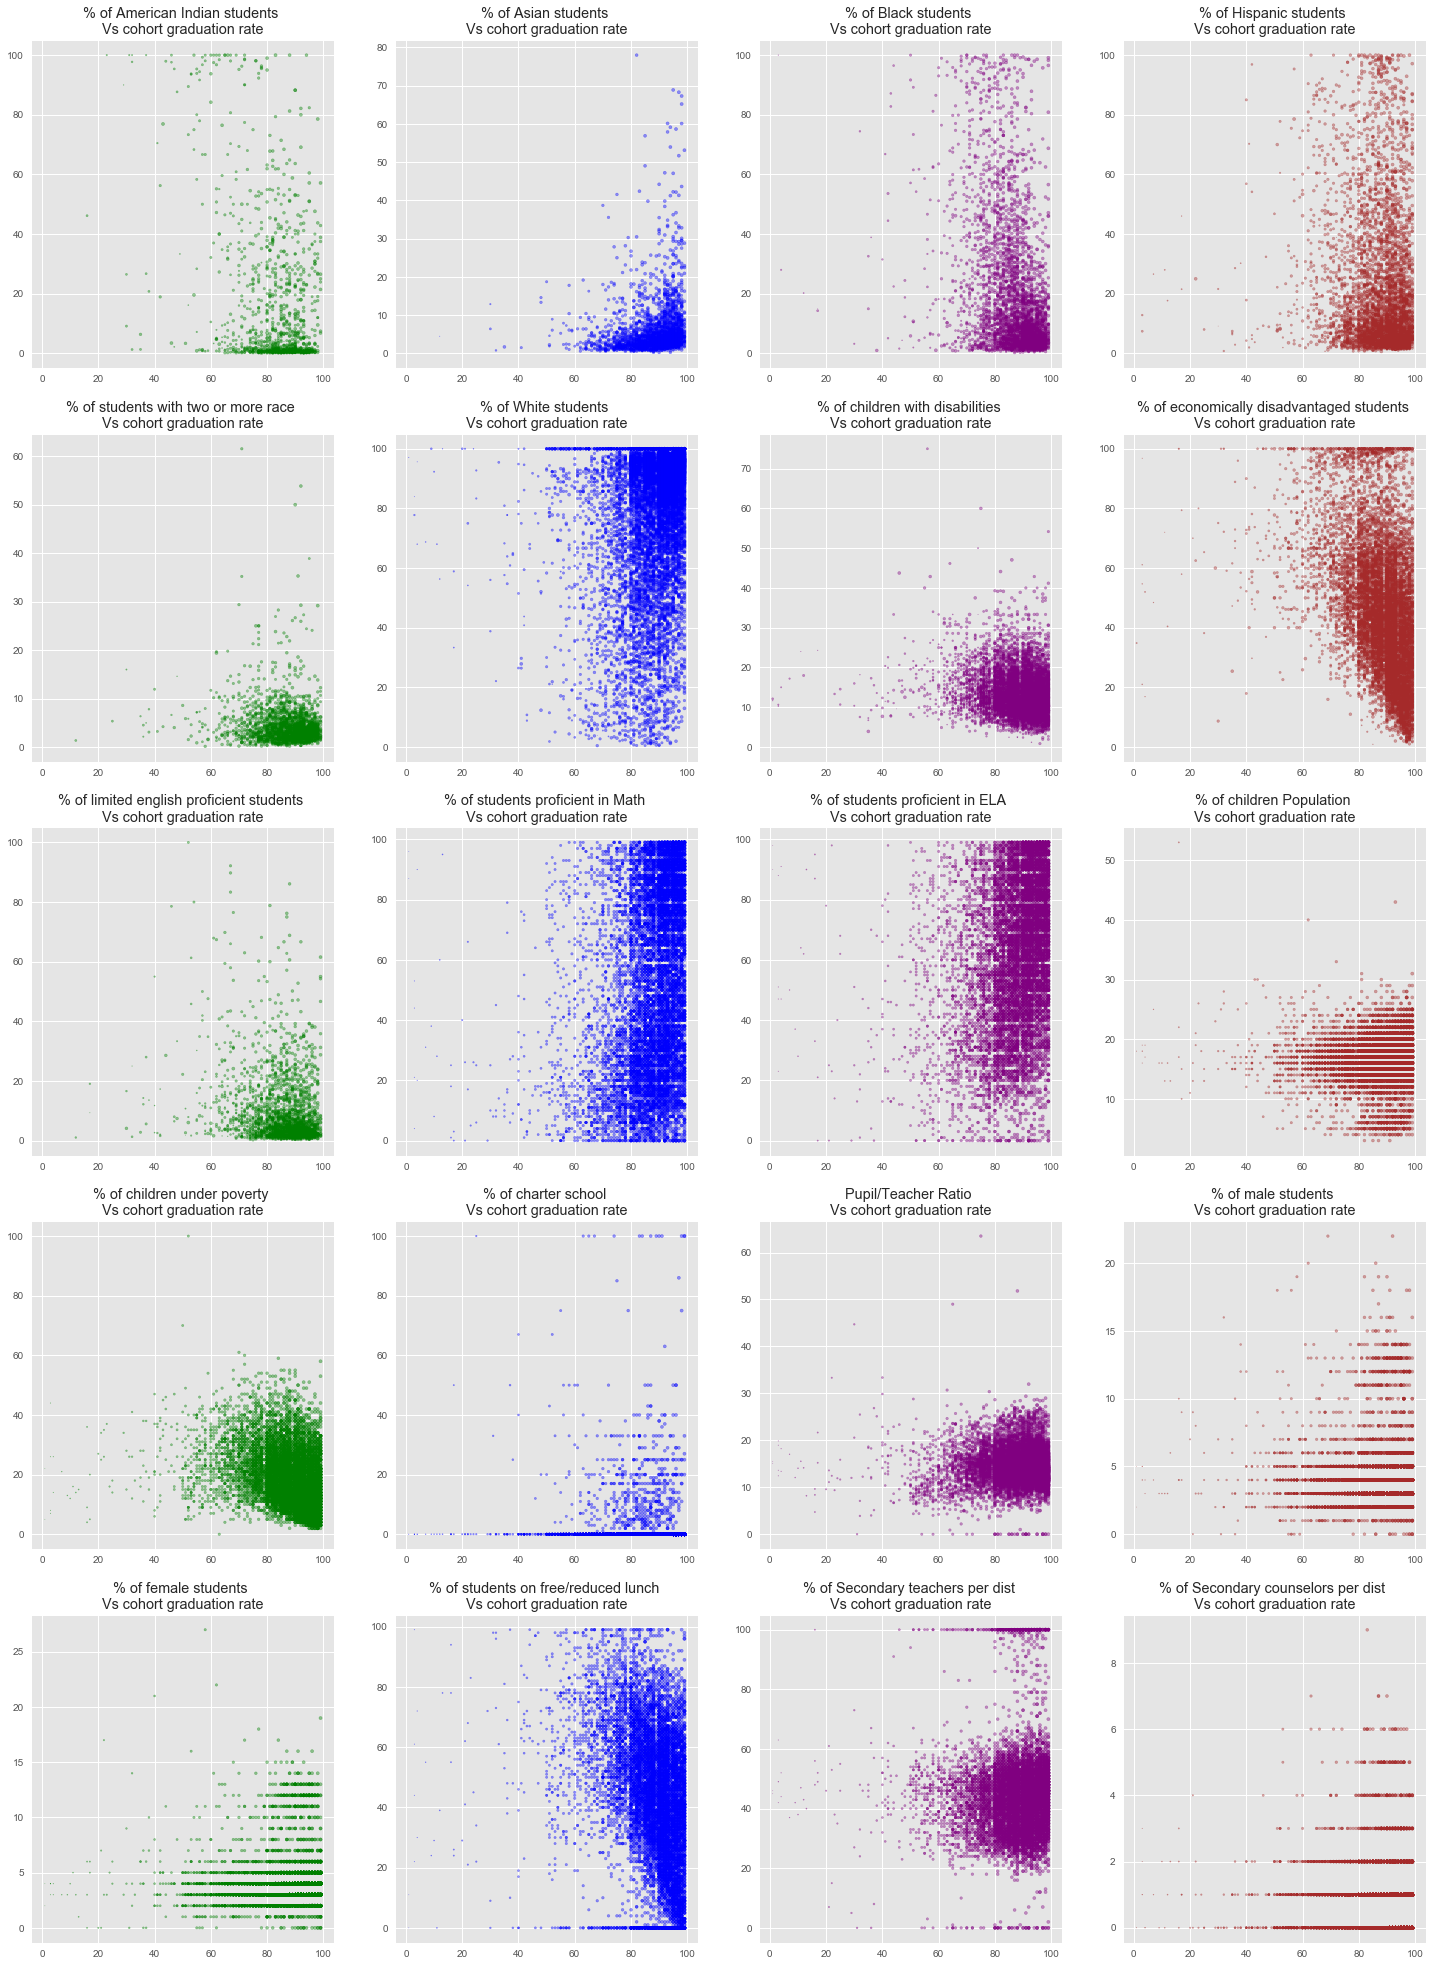

In [17]:
acgr2014 = acgr2014.fillna(0)

a = acgr2014['ALLP']
b = acgr2014['MAMR']
c = acgr2014['MASR']
d = acgr2014['MBLR']
e = acgr2014['MHIR']
f = acgr2014['MTRR']
g = acgr2014['MWHR']
h = acgr2014['CWDR']
i = acgr2014['ECDR']
j = acgr2014['LEPR']
k = acgr2014['MTHP']
l = acgr2014['RLAP']
m = acgr2014['CHIR']
n = acgr2014['POVR']
o = acgr2014['CHSR']
p = acgr2014['PUTR']
q = acgr2014['MLSR']
r = acgr2014['FLSR']
s = acgr2014['FRLR']
t = acgr2014['SETR']
u = acgr2014['SECR']

fig, ax = plt.subplots(5, 4, figsize=(25, 35))

area = acgr2014['MAMP']/10
ax[0, 0].scatter(a, b, s=area, color='green', alpha=0.4)
ax[0, 0].set_title("% of American Indian students \nVs cohort graduation rate")

area = acgr2014['MASP']/10
ax[0, 1].scatter(a, c, s=area, color='blue', alpha=0.4)
ax[0, 1].set_title("% of Asian students \nVs cohort graduation rate")

area = acgr2014['MBLP']/10
ax[0, 2].scatter(a, d, s=area, color='purple', alpha=0.4)
ax[0, 2].set_title("% of Black students \nVs cohort graduation rate");

area = acgr2014['MHIP']/10
ax[0, 3].scatter(a, e, s=area, color='brown', alpha=0.4)
ax[0, 3].set_title("% of Hispanic students \nVs cohort graduation rate");

area = acgr2014['MTRP']/10
ax[1, 0].scatter(a, f, s=area, color='green', alpha=0.4)
ax[1, 0].set_title("% of students with two or more race \nVs cohort graduation rate");

area = acgr2014['MWHP']/10
ax[1, 1].scatter(a, g, s=area, color='blue', alpha=0.4)
ax[1, 1].set_title("% of White students \nVs cohort graduation rate");

area = acgr2014['CWDP']/10
ax[1, 2].scatter(a, h, s=area, color='purple', alpha=0.4)
ax[1, 2].set_title("% of children with disabilities \nVs cohort graduation rate");

area = acgr2014['ECDP']/10
ax[1, 3].scatter(a, i, s=area, color='brown', alpha=0.4)
ax[1, 3].set_title("% of economically disadvantaged students \nVs cohort graduation rate");

area = acgr2014['LEPP']/10
ax[2, 0].scatter(a, j, s=area, color='green', alpha=0.4)
ax[2, 0].set_title("% of limited english proficient students \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[2, 1].scatter(a, k, s=area, color='blue', alpha=0.4)
ax[2, 1].set_title("% of students proficient in Math \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[2, 2].scatter(a, l, s=area, color='purple', alpha=0.4)
ax[2, 2].set_title("% of students proficient in ELA \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[2, 3].scatter(a, m, s=area, color='brown', alpha=0.4)
ax[2, 3].set_title("% of children Population \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[3, 0].scatter(a, n, s=area, color='green', alpha=0.4)
ax[3, 0].set_title("% of children under poverty \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[3, 1].scatter(a, o, s=area, color='blue', alpha=0.4)
ax[3, 1].set_title("% of charter school \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[3, 2].scatter(a, p, s=area, color='purple', alpha=0.4)
ax[3, 2].set_title("Pupil/Teacher Ratio \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[3, 3].scatter(a, q, s=area, color='brown', alpha=0.4)
ax[3, 3].set_title("% of male students \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[4, 0].scatter(a, r, s=area, color='green', alpha=0.4)
ax[4, 0].set_title("% of female students \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[4, 1].scatter(a, s, s=area, color='blue', alpha=0.4)
ax[4, 1].set_title("% of students on free/reduced lunch \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[4, 2].scatter(a, t, s=area, color='purple', alpha=0.4)
ax[4, 2].set_title("% of Secondary teachers per dist \nVs cohort graduation rate");

area = acgr2014['ALLP']/10
ax[4, 3].scatter(a, u, s=area, color='brown', alpha=0.4)
ax[4, 3].set_title("% of Secondary counselors per dist \nVs cohort graduation rate");

plt.show()

#### Hence we are going to draw the heatmap of all these variables which may have an impact on overall graduation rate.

In [18]:
columns = ['MAMR','MASR','MBLR','MHIR','MTRR','MWHR','CWDR','ECDR','LEPR','MTHP', 
           'RLAP','CHIR','POVR','CHSR','PUTR','MLSR','FLSR','FRLR','SETR','SECR']

acgr = acgr2014[columns]
corr = acgr.corr()

In [19]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "10pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '100px'),
                        ('font-size', '10pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '70px', 'font-size': '9pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,MAMR,MASR,MBLR,MHIR,MTRR,MWHR,CWDR,ECDR,LEPR,MTHP,RLAP,CHIR,POVR,CHSR,PUTR,MLSR,FLSR,FRLR,SETR,SECR
MAMR,1,-0.051,-0.086,-0.07,0.08,-0.29,0.11,0.19,0.11,-0.091,-0.12,0.1,0.16,0.0078,-0.068,0.018,0.01,0.22,0.03,0.032
MASR,-0.051,1,0.021,0.097,0.05,-0.24,-0.039,-0.11,0.2,0.00093,0.047,-0.075,-0.18,0.045,0.21,0.099,0.1,-0.26,-0.0014,0.12
MBLR,-0.086,0.021,1,-0.038,-0.01,-0.57,-0.01,0.36,-0.0036,-0.15,-0.19,-0.038,0.41,0.0092,0.028,-0.13,-0.093,0.37,-0.09,0.022
MHIR,-0.07,0.097,-0.038,1,-0.031,-0.67,-0.08,0.35,0.62,-0.1,-0.16,0.13,0.25,0.076,0.2,-0.016,-0.014,0.088,-0.021,-0.061
MTRR,0.08,0.05,-0.01,-0.031,1,-0.13,0.083,0.052,-0.023,0.002,0.025,-0.031,0.017,0.037,0.14,-0.011,-0.021,0.061,-0.021,-0.027
MWHR,-0.29,-0.24,-0.57,-0.67,-0.13,1,0.02,-0.54,-0.51,0.2,0.26,-0.089,-0.47,-0.074,-0.18,0.072,0.05,-0.35,0.062,-0.00087
CWDR,0.11,-0.039,-0.01,-0.08,0.083,0.02,1,0.12,-0.04,0.0036,-0.0056,-0.12,0.028,-0.033,-0.12,0.012,0.019,0.066,-0.018,0.048
ECDR,0.19,-0.11,0.36,0.35,0.052,-0.54,0.12,1,0.36,-0.34,-0.36,-0.016,0.72,0.086,0.044,-0.1,-0.092,0.63,-0.081,-0.047
LEPR,0.11,0.2,-0.0036,0.62,-0.023,-0.51,-0.04,0.36,1,-0.21,-0.2,0.081,0.21,0.098,0.21,0.024,0.019,0.05,-0.028,0.04
MTHP,-0.091,0.00093,-0.15,-0.1,0.002,0.2,0.0036,-0.34,-0.21,1,0.81,0.11,-0.22,-0.12,-0.13,-0.12,-0.12,-0.17,0.0072,-0.12


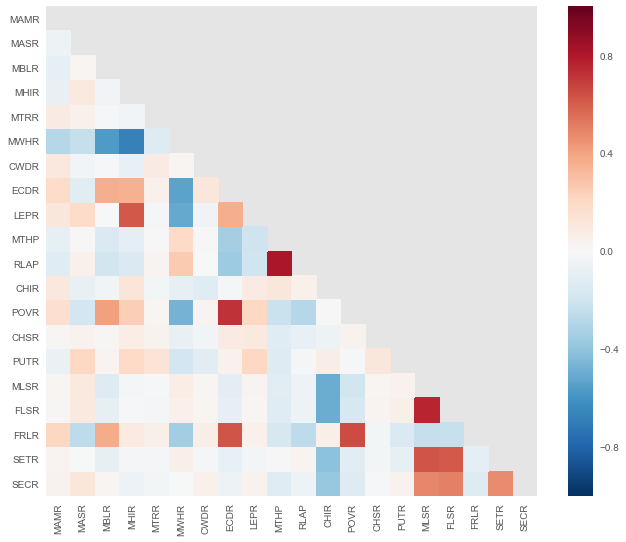

In [20]:
fig = plt.figure(figsize = (11,9))
mask = np.zeros_like(acgr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(acgr.corr(), mask = mask);

#### Now we are going to apply some machine learning technique to our dataset and see if we can predict a model.

In [30]:
columns = ['MAMR','MASR','MBLR','MHIR','MTRR','MWHR','CWDR','ECDR','LEPR','MTHP','RLAP','POVR','MLSR','FLSR','FRLR','SETR']
#columns = ['MAMR','MASR','MBLR','MHIR','MWHR','ECDR','LEPR','MTHP','RLAP','POVR','MLSR','FLSR','SETR']

X = acgr2014[columns]
y = acgr2014['ALLP']

## Linear Regression Model

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

y_pred = model.predict(X_test)

lm_score = model.score(X_test, y_test)

#print(pd.DataFrame(lm.coef_, index = X.columns, columns = ['estimatedCoefficients']))
print('Training R2 on AGCR Linear Model prediction {}'.format(lm_score))
print('MSE for training response data: {:.2f}'.format(np.mean((lm.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((lm.predict(X_test) - y_test) ** 2)))

#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lm_acgr_cv = LinearRegression(normalize = True)

#Find MSE on response time prediction
scores = cross_val_score(lm_acgr_cv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

Training R2 on AGCR Linear Model prediction 0.19963620115105007
MSE for training response data: 86.42
MSE for test response data: 96.68
MSE: 87.22 
SE: 5.71


Estimated intercept coefficient: 52.657861096
Number of coefficients: 16
   features  estimatedCoefficients
0      MAMR               0.264814
1      MASR               0.492325
2      MBLR               0.363579
3      MHIR               0.413001
4      MTRR               0.327551
5      MWHR               0.404486
6      CWDR              -0.183126
7      ECDR              -0.065613
8      LEPR              -0.106404
9      MTHP               0.038625
10     RLAP               0.018393
11     POVR              -0.063695
12     MLSR              -0.163687
13     FLSR              -0.159668
14     FRLR              -0.046538
15     SETR               0.026454
[ 85.71584053  83.51207442  91.13065894  91.68076823  82.68754816]


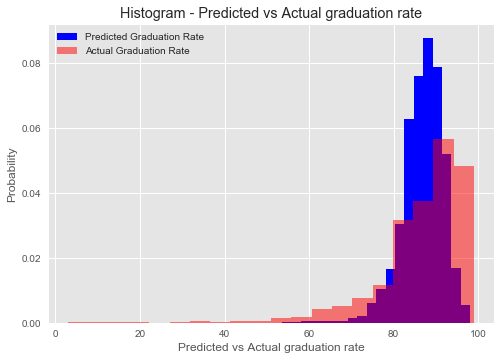

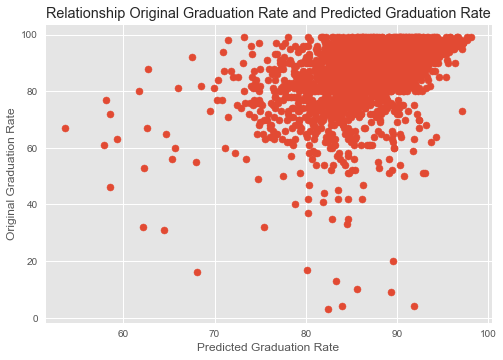

96.68455884179023


In [32]:
from sklearn.linear_model import LinearRegression

print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))

# The coefficients
print(pd.DataFrame(list(zip(X.columns, lm.coef_)), columns = 
                  ['features', 'estimatedCoefficients']))
print(lm.predict(X)[0:5])

#X_new = lm.predict(X)
#X_old = tempDf['ALLP']

plt.hist(y_pred, bins=20, histtype='bar', normed=True, color='b', label='Predicted Graduation Rate')
plt.hist(y_test, bins=20, histtype='bar', normed=True, color='r', alpha=0.5, label='Actual Graduation Rate')
plt.title("Histogram - Predicted vs Actual graduation rate")
plt.xlabel("Predicted vs Actual graduation rate")
plt.ylabel("Probability")
plt.legend()
plt.show()

plt.scatter(y_pred, y_test)
plt.xlabel("Predicted Graduation Rate")
plt.ylabel("Original Graduation Rate")
plt.title("Relationship Original Graduation Rate and Predicted Graduation Rate")
plt.show()

print(np.mean((y_pred - y_test) ** 2))

(18553, 16) (18553, 1)
(2062, 16) (2062, 1)


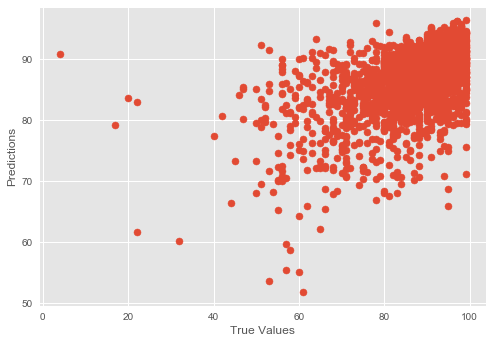

Score: 0.249167469352


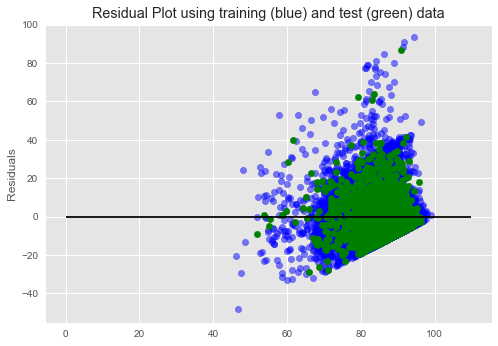

In [33]:
df = tempDf[columns]
y = tempDf[['ALLP']]

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

print("Score:", model.score(X_test, y_test))

plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 110)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

plt.show()

In [39]:
X = acgr2014[columns]
y = acgr2014['ALLP']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Random Forest Model

Training R2 on AGCR Random Forest prediction 0.2232372244384313
MSE for training response data: 15.86
MSE for test response data: 93.83
MSE: 90.17577800780873 
SE: 6.058018178246579


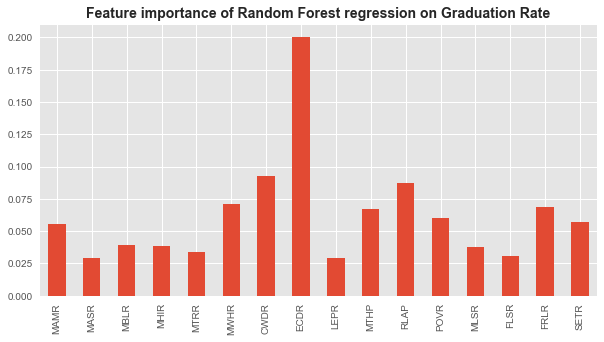

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf_agrc = RandomForestRegressor(random_state = 10)

rf_agrc.fit(X_train, y_train)

agrc_score = rf_agrc.score(X_test, y_test)

print('Training R2 on AGCR Random Forest prediction {}'.format(agrc_score))
print('MSE for training response data: {:.2f}'.format(np.mean((rf_agrc.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_agrc.predict(X_test) - y_test) ** 2)))

#Find MSE on Graduation Rate prediction using 5 K-folds
kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_agrc, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

agrc_features = pd.Series(rf_agrc.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(10,5));
agrc_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on Graduation Rate', fontsize = 14, fontweight = 'bold');

In [41]:
X = acgr2014[columns]
y = acgr2014['ALLP']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Gradient Boosting Model

MSE: 88.6711
R2: 0.2660


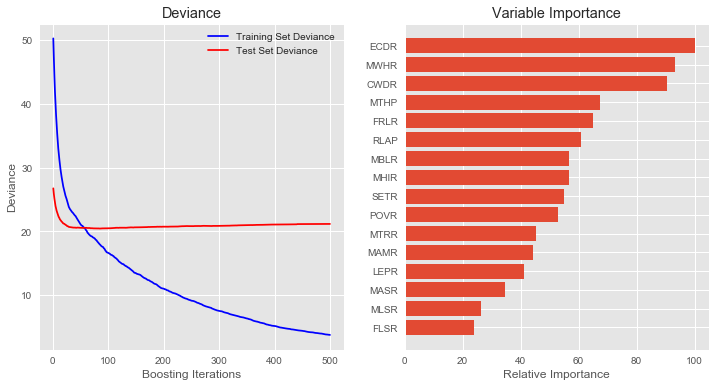

In [42]:
import random
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gbr = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gbr.predict(X_test))
r2 = r2_score(y_test, gbr.predict(X_test))

print("MSE: %.4f" % mse)
print("R2: %.4f" % r2)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = gbr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()